<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, Kiryll Bykov, Alexey Boldyrev ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus vs Mars</font>](https://www.kaggle.com/competitions/19feb24hse-venusmars/rules)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.

At first take kaggle.json from https://www.kaggle.com/settings/account "Create New Token"

In [ ]:
# from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

In [ ]:
%%capture
pip install -U kaggle  # upgrade kaggle package (to avoid a warning)

In [ ]:
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json           # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 19feb24hse-venusmars # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download                     # download competition dataset as a zip file
!unzip -o *.zip                                   # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/female/fx10119.jpg  
  inflating: train/female/fx10126.jpg  
  inflating: train/female/fx10171.jpg  
  inflating: train/female/fx10174.jpg  
  inflating: train/female/fx101a2.jpg  
  inflating: train/female/fx101ce.jpg  
  inflating: train/female/fx101d1.jpg  
  inflating: train/female/fx101e5.jpg  
  inflating: train/female/fx1023c.jpg  
  inflating: train/female/fx10243.jpg  
  inflating: train/female/fx1025f.jpg  
  inflating: train/female/fx1026c.jpg  
  inflating: train/female/fx10295.jpg  
  inflating: train/female/fx102a6.jpg  
  inflating: train/female/fx102f.jpg  
  inflating: train/female/fx10380.jpg  
  inflating: train/female/fx103b1.jpg  
  inflating: train/female/fx103c4.jpg  
  inflating: train/female/fx103eb.jpg  
  inflating: train/female/fx103ee.jpg  
  inflating: train/female/fx104cf.jpg  
  inflating: train/female/fx104d6.jpg  
  inflating: train/female/fx104d7.jpg  
  inflating: 

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
from torch.utils.data import random_split
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d
import torchvision
from torchvision.models import resnet50, mobilenet_v2, mobilenet_v3_small
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 3.69 s, sys: 407 ms, total: 4.1 s
Wall time: 4.86 s


Examples of images from female class

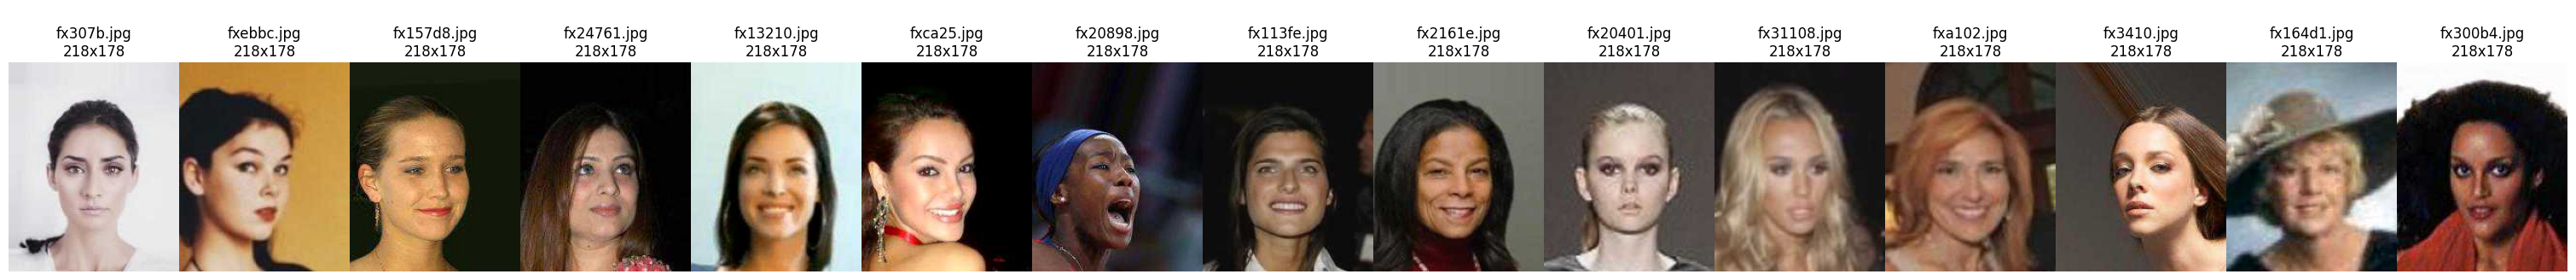

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

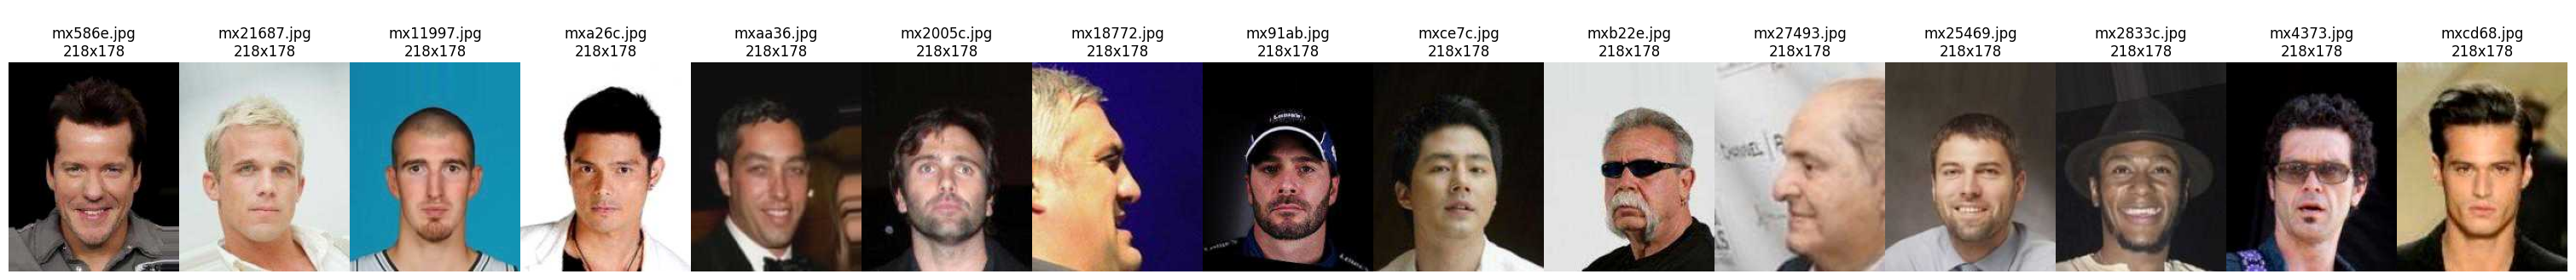

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

I decided to convert images into arrays for easier manipulation. For each image, I selected a 50 by 50 pixel square, focusing on the face itself rather than the original 218 by 178 dimensions. This helps the model to learn more effectively without being distracted by unnecessary background details. Additionally, each image was converted to grayscale to improve the model's quality. All pixel values were normalized by dividing by 255, the maximum color value.

## **Task 2.2**

**Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

I decided to use a Convolutional Neural Network (CNN) as it is a widely used and effective method for gender classification in deep learning. First, I performed data augmentation to create variations of the training images, which improves the robustness and generalization of the gender classification model.Then I built the CNN model with 7 layers and ReLU activation functions. To assess the model's quality, I evaluated the accuracy and validation loss for both the training and validation sets. Throughout this process, I experimented with different parameters, including the number of pixels used, the number of epochs, the number of layers, the learning rate, and the number of output neurons in each layer.

Reading files for training a model and creating filies to make predictions

In [ ]:
male = os.listdir(tDIR+'male/')
female = os.listdir(tDIR+'female/')

In [ ]:
!mv test/ labels/ && mkdir test && mv labels/ test/labels/ # WHEN you run this string once you need to comment it

In [ ]:
im_folder_test = ImageFolder(sDIR)

In [ ]:
sDL = DataLoader(im_folder_test, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
vIDs = [f[0].split('/')[-1].split(',')[0] for f in sDL.dataset.imgs] # parse image IDs from file names IT IS TEST DATA

In [ ]:
from PIL import Image
import cv2

<font color=white><h3><b>Preprocessing</b><h3>

In [ ]:
data = []
gender = [] # 0 - woman, 1 - man
for i in range(len(male)):
  img = cv2.imread(tDIR+'male/' + male[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (50,50)) # 55,55
  img = np.expand_dims(img, axis=-1)
  img = img.astype('float32')
  img /= 255.0
  data.append(img)
  gender.append(1)

for i in range(len(female)):
  img = cv2.imread(tDIR+'female/' + female[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (50,50))
  img = np.expand_dims(img, axis=-1)
  img = img.astype('float32')
  img /= 255.0
  data.append(img)
  gender.append(0)

In [ ]:
gender = np.array(gender)
data = np.array(data)

In [ ]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(data, gender, test_size=0.2, stratify = gender, random_state=42)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization,Conv1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from keras.optimizers import Adam,Adagrad
from tensorflow.keras.models import load_model
import numpy as np

Data augmentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=0.5, width_shift_range=0.01,
                         height_shift_range=0.01, shear_range=0.01, zoom_range=0.01,
                         horizontal_flip=True, fill_mode="nearest")

<font color=white><h3><b>Training a model</b><h3>

In [ ]:
epochs=105
optim = Adam(learning_rate=0.0025)

In [ ]:
model = Sequential()
model.add(Convolution2D(32, (3,3), padding="same", input_shape=(50,50, 1)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))

model.add(Convolution2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))

model.add(Convolution2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=60),
                        validation_data=(X_test,y_test),
                        epochs=epochs, verbose=2)

Epoch 1/105


<ipython-input-22-29f6f9dd4157>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=60),


67/67 - 11s - loss: 1.1003 - accuracy: 0.6030 - val_loss: 0.9256 - val_accuracy: 0.4180 - 11s/epoch - 165ms/step
Epoch 2/105
67/67 - 3s - loss: 0.6928 - accuracy: 0.6727 - val_loss: 0.6664 - val_accuracy: 0.5960 - 3s/epoch - 47ms/step
Epoch 3/105
67/67 - 2s - loss: 0.6061 - accuracy: 0.7205 - val_loss: 0.7095 - val_accuracy: 0.4760 - 2s/epoch - 29ms/step
Epoch 4/105
67/67 - 2s - loss: 0.4688 - accuracy: 0.7893 - val_loss: 0.8009 - val_accuracy: 0.4340 - 2s/epoch - 30ms/step
Epoch 5/105
67/67 - 2s - loss: 0.4171 - accuracy: 0.8127 - val_loss: 0.8036 - val_accuracy: 0.5110 - 2s/epoch - 29ms/step
Epoch 6/105
67/67 - 2s - loss: 0.3973 - accuracy: 0.8290 - val_loss: 0.4183 - val_accuracy: 0.8120 - 2s/epoch - 29ms/step
Epoch 7/105
67/67 - 2s - loss: 0.3300 - accuracy: 0.8602 - val_loss: 0.2906 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 8/105
67/67 - 3s - loss: 0.3147 - accuracy: 0.8680 - val_loss: 0.5553 - val_accuracy: 0.8010 - 3s/epoch - 42ms/step
Epoch 9/105
67/67 - 2s - loss: 0.

<font color=white><h3><b>Making predictions</b><h3>

In [ ]:
faces = []
for i in range(len(vIDs)):
  img = cv2.imread(sDIR + 'labels/' + vIDs[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (50,50))
  img = np.expand_dims(img, axis=-1)
  img = img.astype('float32')
  img /= 255.0
  faces.append(img)

In [ ]:
faces = np.array(faces)
predictions = model.predict(faces)

157/157 [==============================] - 1s 3ms/step


In [ ]:
predictions

array([[0.  , 1.  ],
       [0.37, 0.72],
       [1.  , 0.  ],
       [0.29, 0.81],
       [0.  , 1.  ],
       ...,
       [0.23, 0.74],
       [0.8 , 0.21],
       [0.98, 0.01],
       [0.  , 1.  ],
       [0.  , 1.  ]], dtype=float32)

In [ ]:
gender_pred = []
for i in range(len(predictions)):
  if predictions[i][0] > predictions[i][1]:
    gender_pred.append(0)
  else:
    gender_pred.append(1)

In [ ]:
vIDs = [vIDs[i][0:-4] for i in range(len(vIDs))]

In [ ]:
data = {'y': gender_pred}
df_new = pd.DataFrame(data)
df_new.index = vIDs
df_new

,y
x10a06,1
x10a2d,1
...,...
x9fad,1
x9fae,1


In [ ]:
ToCSV(df_new, 'Venus')

# **References:**

1. Gender-Detection-Using-Deep-Learning. — Text: electronic// Github : [website]. — URL: https://github.com/ramiikhaliid/Gender-Detection-Using-Deep-Learning/blob/main/Gender%20detection%20.ipynb

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 279 sec


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.